# Informatyka w medycynie, Tomograf

In [1]:
from PIL import Image
from matplotlib import cm
import numpy as np
from math import degrees, radians, pi

In [2]:
# image padding - so that emiters can go in circle around it
def make_square(im):
  x, y = im.size
  maximum = max(x,y)
  size = int(np.ceil(np.sqrt(2 * maximum**2)))
  new_im = Image.new('L', (size, size))
  new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
  return new_im

(1024, 1024)


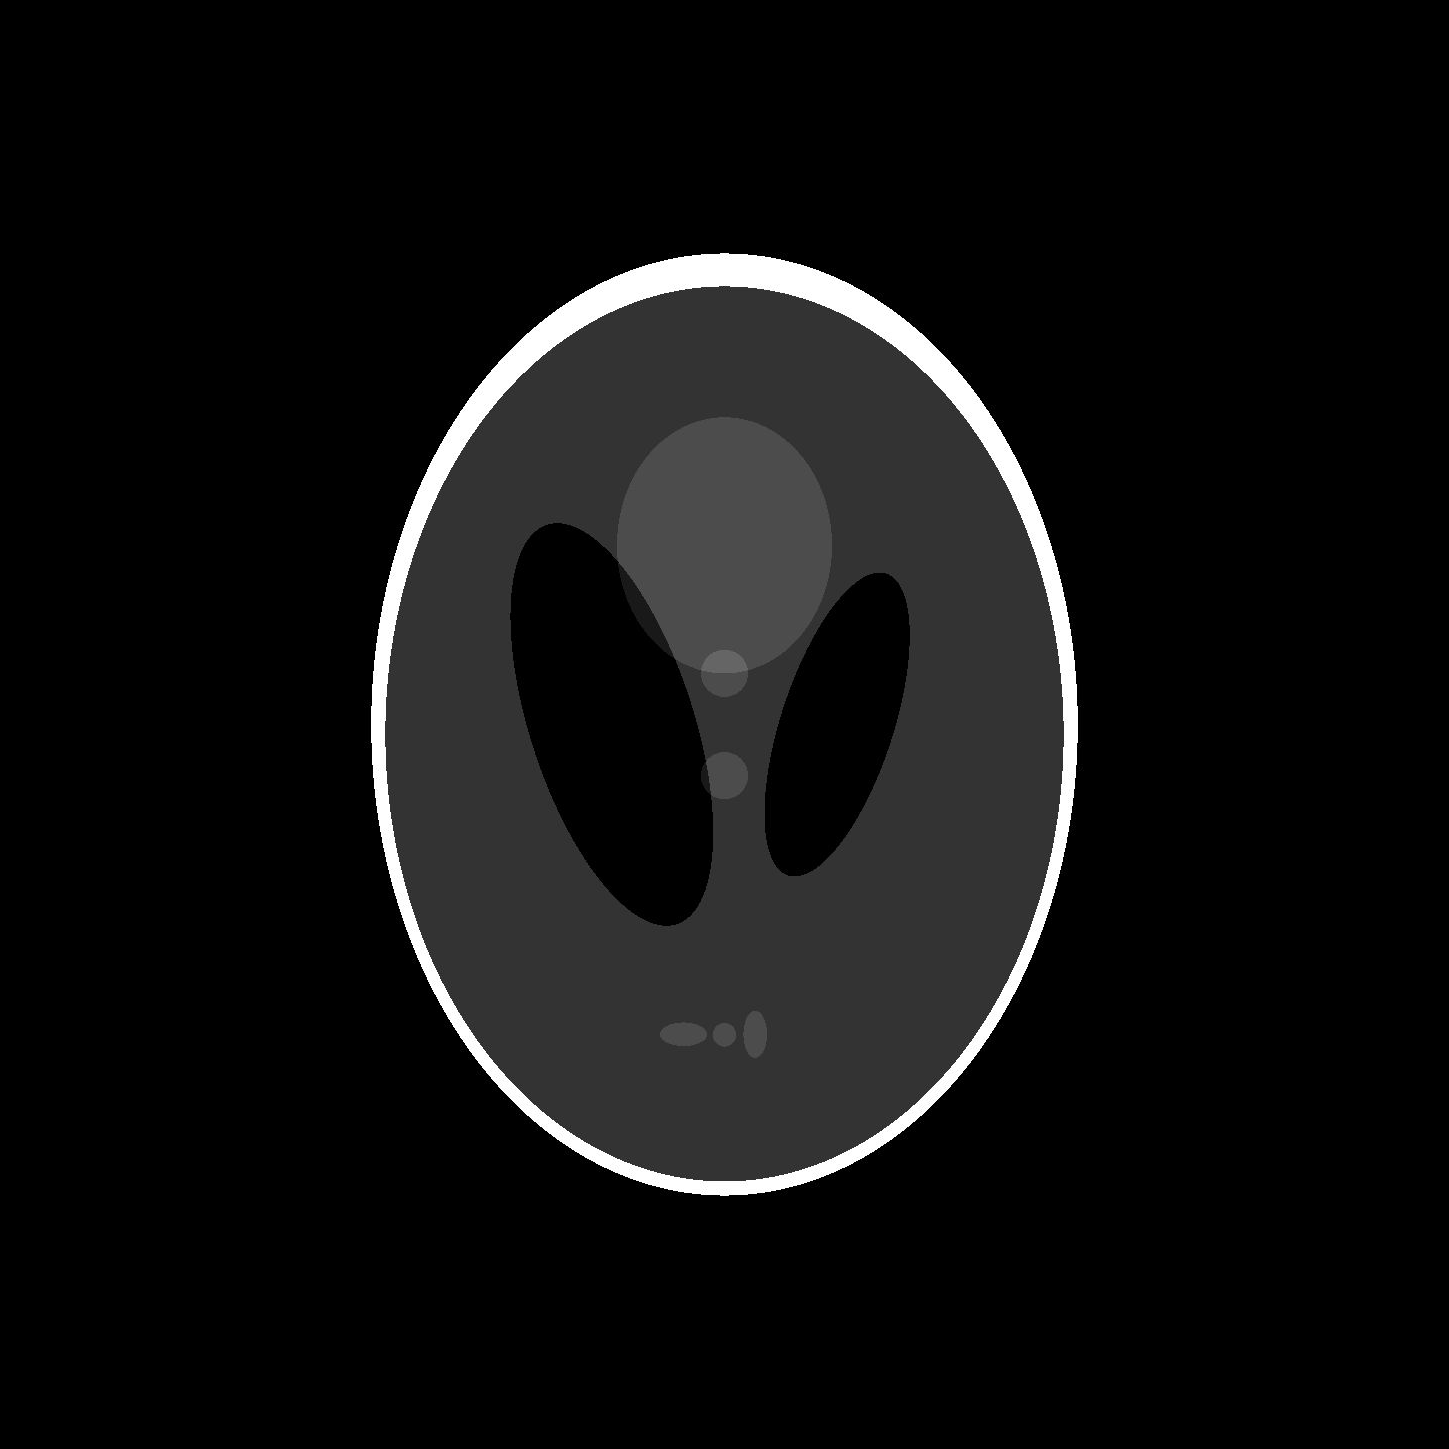

In [4]:
img =  Image.open("Shepp_logan.jpg").convert('L')
img_shape = np.array(img).shape
img = make_square(img)
img

In [5]:
img_array = np.array(img)
img_array.shape

(1024, 1024)

In [ ]:
def angles_to_coords(image, angles):
  angles_radians = [radians(angle) for angle in (angles - 90)]
  center = (np.array(image.shape) / 2)[0]
  r = image.shape[0] // 2
  x = r * np.cos(angles_radians) + center
  y = r * np.sin(angles_radians) + center
  coords = np.floor(np.array(list(zip(x, y)))).astype(int)
  return coords

def calculate_coords(image, angle, detector_number, span, detector=False):
  angles = (np.linspace(0, span, detector_number) + angle - 1/2*span) % 360
  if detector:
    angles = ((angles + 180) % 360)[::-1]

  coords = angles_to_coords(image, angles)
  return coords

def bresenham(x1, y1, x2, y2):
  swap = False
  if abs(y2 - y1) > abs(x2 - x1):
    swap = True
    x1, y1 = y1, x1
    x2, y2 = y2, x2
  dx = x2 - x1
  dy = y2 - y1  
  m = dy / dx if dx != 0 else 1
  q = y1 - m * x1
  if x1 < x2:
    xs = np.arange(np.floor(x1), np.ceil(x2) + 1, 1, dtype=int)
  else:
    xs = np.arange(np.ceil(x1), np.floor(x2) - 1, -1, dtype=int)
  ys = np.round(m * xs + q).astype(int)
  if swap:
    return (ys, xs)
  else:
    return (xs, ys)

def normalize(array):
  array = np.array(array)
  array = array.astype('float32')
  array -= np.min(array)
  array /= np.max(array)
  return array    

In [ ]:
def radon_transform(image, alpha, detector_number, span):
  scan_number = int(180 / alpha) 
  angles = np.linspace(0, 180, scan_number)
  sinogram = np.zeros((scan_number, detector_number))
  for i, angle in enumerate(angles):
    emiter_coords = calculate_coords(image, angle, detector_number, span, detector=False)
    detector_coords = calculate_coords(image, angle, detector_number, span, detector=True)
    bresenham_lines = [bresenham(x1, y1, x2, y2) for (x1, y1), (x2, y2) in zip(emiter_coords, detector_coords)]
    results = []
    for line in bresenham_lines:
      results.append(np.sum(image[tuple(line)]))
    sinogram[i] = normalize(results)

  return sinogram

In [ ]:
sinogram = radon_transform(img_array, 0.5, 360, 270)

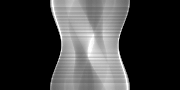

In [ ]:
PIL_image = Image.fromarray(np.uint8(sinogram * 255), 'L')
PIL_image

In [ ]:
def reshape_to_original(image, size):
  shape = image.shape[0]
  x = np.floor((shape / 2) - (size[1] / 2)).astype(int)
  y = np.floor((shape / 2) - (size[0] / 2)).astype(int)
  reshaped = image[y:y+size[0], x:x+size[1]]
  return reshaped

def tresh(array, min, max):
    array[array < min] = min
    array[array > max] = max
    return array

import scipy.signal as sig

def create_mask(size):
  mask = np.zeros(size)
  center = int(size/2)
  mask[center] = 1.0
  for i in range(center+1, len(mask)):
    dist = i-center
    if dist % 2 == 0:
      mask[i] = 0.0
      mask[center-dist] = 0.0
    else:
      mask[i] = (-4/pow(pi,2))/pow(dist,2)
      mask[center-dist] = mask[i]      
  return mask

from scipy.ndimage import convolve

def inverse_radon_transform(sinogram, size, span, filter=True):
  scan_number, detector_number = sinogram.shape
  if filter:
    mask = create_mask(detector_number)
    for i in range(scan_number):
      sinogram[i,:] = np.convolve(sinogram[i,:], mask, 'same')
    sinogram = tresh(np.real(sinogram), 0, 1)
    PIL_image = Image.fromarray(np.uint8(sinogram * 255), 'L')
    PIL_image.show()
    
    
  pil_image = Image.new('L', size)
  pil_image = make_square(pil_image)
  image = np.array(pil_image).astype('float64')
  count = image.copy()
  angles = np.linspace(0, 180, scan_number)
  
  for i, angle in enumerate(angles):
    emiter_coords = calculate_coords(image, angle, detector_number, span, detector=False)
    detector_coords = calculate_coords(image, angle, detector_number, span, detector=True)
    bresenham_lines = [np.array(bresenham(x1, y1, x2, y2)) for (x1, y1), (x2, y2) in zip(emiter_coords, detector_coords)]
    for j, line in enumerate(bresenham_lines):
      image[tuple(line)] += sinogram[i][j]
      count[tuple(line)] += 1 
  count[count == 0] = 1
  image = image / count
  image = normalize(image)
    
  image = reshape_to_original(image, size)  
  return image  

In [ ]:
image_after = inverse_radon_transform(sinogram, img_shape, 270, True)

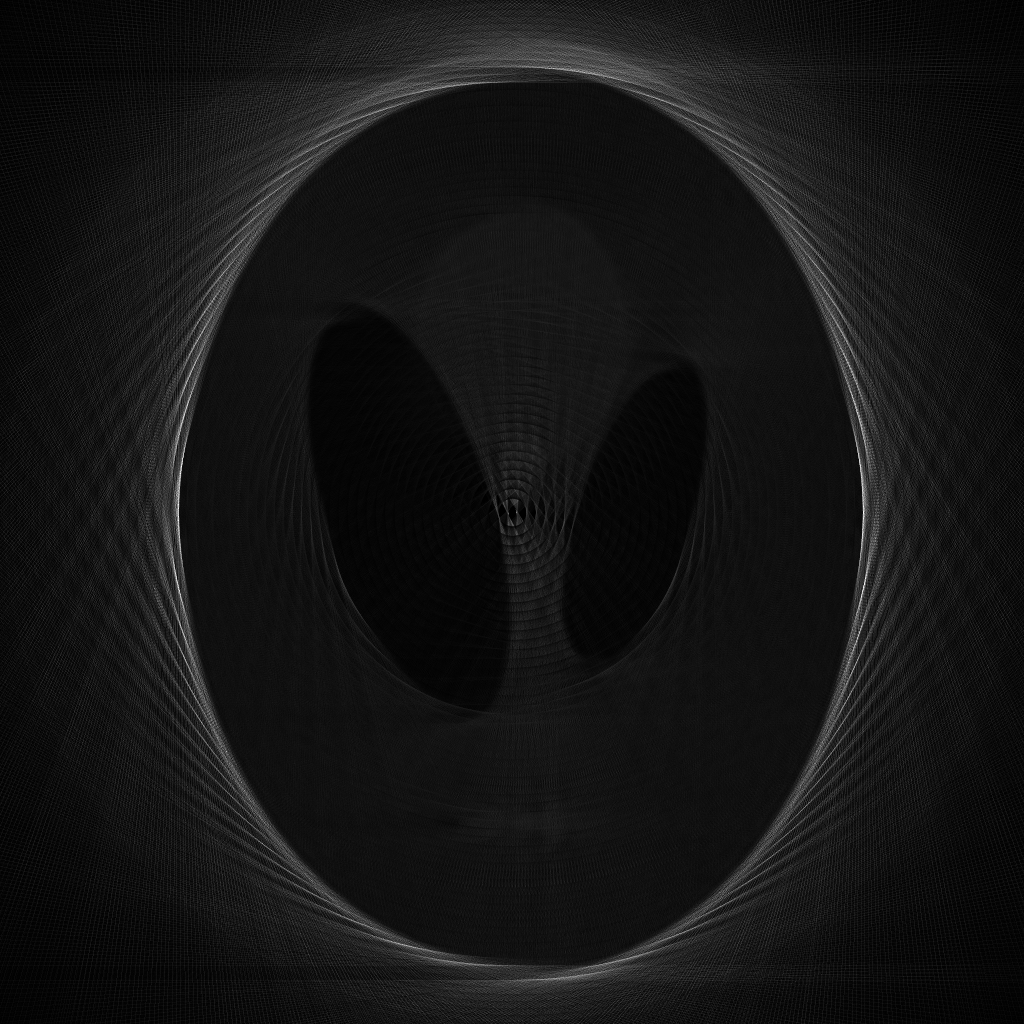

In [ ]:
PIL_image = Image.fromarray(np.uint8(image_after * 255), 'L')
PIL_image

In [ ]:
import matplotlib.pyplot as plt 
def rmsdiff(im1, im2):
  return np.sqrt(np.mean((im1-im2)**2))

In [ ]:
rmse_results_detectors = []
for i in range(90, 721, 90):
  img =  Image.open("Shepp_logan.jpg").convert('L')
  img_np = np.array(img)
  img_array = np.array(make_square(img))
  sinogram = radon_transform(img_array, 1, i, 180)
  img_after = inverse_radon_transform(sinogram, (1024,1024), 180, False)
  rmse_results_detectors.append(rmsdiff(img_np/255, img_after))

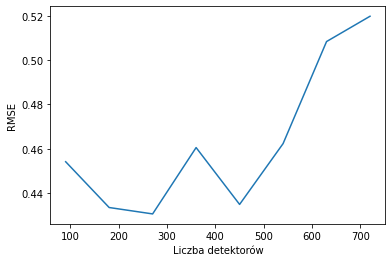

In [ ]:
x = list(range(90,721,90))
plt.plot(x, rmse_results_detectors)
plt.xlabel("Liczba detektorów")
plt.ylabel("RMSE")
plt.savefig("detectors.png", dpi=200)

In [ ]:
rmse_results_scan_number = []
alphas = [180/i for i in range(90, 721, 90)]
for i in alphas:
  img =  Image.open("Shepp_logan.jpg").convert('L')
  img_np = np.array(img)
  img_array = np.array(make_square(img))
  sinogram = radon_transform(img_array, i, 180, 180)
  img_after = inverse_radon_transform(sinogram, (1024,1024), 180, False)
  rmse_results_scan_number.append(rmsdiff(img_np/255, img_after))

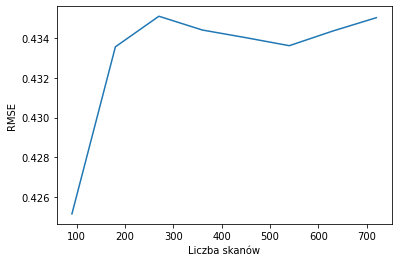

In [ ]:
x = list(range(90,721,90))
plt.plot(x, rmse_results_scan_number)
plt.xlabel("Liczba skanów")
plt.ylabel("RMSE")
plt.savefig("scan_number.png", dpi=200)

In [ ]:
rmse_results_span = []
x = list(range(45, 271, 25))
for i in x:
  img =  Image.open("Shepp_logan.jpg").convert('L')
  img_np = np.array(img)
  img_array = np.array(make_square(img))
  sinogram = radon_transform(img_array, 1, 180, i)
  img_after = inverse_radon_transform(sinogram, (1024,1024), i, False)
  rmse_results_span.append(rmsdiff(img_np/255, img_after))

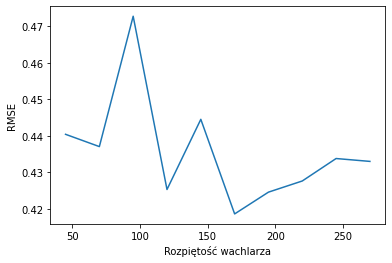

In [ ]:
x = list(range(45, 271, 25))
plt.plot(x, rmse_results_span)
plt.xlabel("Rozpiętość wachlarza")
plt.ylabel("RMSE")
plt.savefig("span.png", dpi=200)